# Introducao

Neste notebook iremos explorar uma base de dados de cerveja. Essas informacoes sao extraidas da API https://punkapi.com/documentation/v2, processadas e armazenadas no AWS Redshift.

Primeiramente iremos fazer algumas analises dos campos da base. Depois iremos testar modelos de aprendizado de maquina para tentar prever p IBU das cervejas.

In [213]:
import json
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import botocore.session as s
import boto3
from botocore.waiter import WaiterModel
from botocore.waiter import create_waiter_with_client
from botocore.exceptions import WaiterError
import operator

## Carregando os dados do Redshift

In [169]:
session = boto3.session.Session()
region = session.region_name

bc_session = s.get_session()

session = boto3.Session(
        botocore_session=bc_session,
        region_name=region,
    )

client_redshift = session.client("redshift-data")
print("Data API client successfully loaded")

Data API client successfully loaded


In [170]:
waiter_name = 'DataAPIExecution'

delay=2
max_attempts=3

#Configure the waiter settings
waiter_config = {
  'version': 2,
  'waiters': {
    'DataAPIExecution': {
      'operation': 'DescribeStatement',
      'delay': delay,
      'maxAttempts': max_attempts,
      'acceptors': [
        {
          "matcher": "path",
          "expected": "FINISHED",
          "argument": "Status",
          "state": "success"
        },
        {
          "matcher": "pathAny",
          "expected": ["PICKED","STARTED","SUBMITTED"],
          "argument": "Status",
          "state": "retry"
        },
        {
          "matcher": "pathAny",
          "expected": ["FAILED","ABORTED"],
          "argument": "Status",
          "state": "failure"
        }
      ],
    },
  },
}

waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

In [171]:
query = 'select * from punk_db.public.tbl_punk;'

res = client_redshift.execute_statement(Database= 'punk_db', 
                                        DbUser='punk_user',
                                        Sql= query, 
                                        ClusterIdentifier= 'punk-redshift-cluster')
print("Redshift Data API execution  started ...")

id = res["Id"]
# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)

output=client_redshift.get_statement_result(Id=id)
nrows=output["TotalNumRows"]
ncols=len(output["ColumnMetadata"])
resultrows=output["Records"]

col_labels=[]
for i in range(ncols): col_labels.append(output["ColumnMetadata"][i]['label'])
                                              
records=[]
for i in range(nrows): records.append(resultrows[i])

redshift_df = pd.DataFrame(np.array(resultrows), columns=col_labels)

Redshift Data API execution  started ...
Done waiting to finish Data API.


In [172]:
beer_df = redshift_df.copy()
def get_value(_dict):
    if 'stringValue' in _dict:
        return _dict['stringValue']
    elif 'longValue' in _dict:
        return _dict['longValue']
    return 'nan'

for i in range(len(beer_df.columns)):
    beer_df[col_labels[i]]=beer_df[col_labels[i]].apply(get_value)

attributes = ['abv', 'ibu', 'target_fg',
              'target_og', 'ebc', 'srm', 'ph']    

for att in attributes:
    beer_df[att] = beer_df[att].astype(float)
    
beer_df

,id,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,1,Buzz,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4
1,2,Trashy Blonde,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4
2,3,Berliner Weisse With Yuzu - B-Sides,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2
3,4,Pilsen Lager,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4
4,5,Avery Brown Dredge,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...,...,...
320,321,Jinx Pale Ale,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
321,322,Jet Trash,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6
322,323,Interstate Vienna Lager.,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2
323,324,Fools Gold Dortmunder Lager,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2


In [173]:
beer_df = beer_df[attributes]
beer_df

,abv,ibu,target_fg,target_og,ebc,srm,ph
0,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4
1,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4
2,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2
3,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4
4,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...
320,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
321,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6
322,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2
323,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2


In [174]:
beer_df.dtypes

abv          float64
ibu          float64
target_fg    float64
target_og    float64
ebc          float64
srm          float64
ph           float64
dtype: object

# KDD

### Estatisticas da base de dados

In [175]:
beer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
abv,325.0,7.906462,4.682521,0.5,5.200,7.2,9.0,55.0
ibu,320.0,65.243750,92.403699,0.0,35.000,50.0,70.0,1157.0
target_fg,324.0,1015.169753,14.488349,1000.0,1010.000,1012.0,1015.0,1125.0
target_og,324.0,1067.530556,27.142109,1007.0,1048.375,1065.0,1080.0,1157.0
ebc,319.0,66.228527,92.306210,2.0,15.000,28.0,70.5,600.0
srm,319.0,33.581881,46.505684,1.0,8.000,15.0,40.0,305.0
ph,323.0,4.641486,4.166788,3.2,4.400,4.4,4.4,79.0


**Traramento de Campos Vazios**

Quantidade de campos vazios de cada atributo:

In [176]:
print(beer_df.shape)
beer_df.isna().sum()

(325, 7)


abv          0
ibu          5
target_fg    1
target_og    1
ebc          6
srm          6
ph           2
dtype: int64

Removendo campos vazios.

In [177]:
# Remove rows with empty IBU
beer_df = beer_df.dropna(subset=['ibu'])

# Replace empty rows with using the average
beer_df = beer_df.fillna(beer_df.mean())

print(beer_df.shape)
beer_df.isna().sum()

(320, 7)


abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

**Histogram dos Atributos Numericos**

array([[<AxesSubplot:title={'center':'abv'}>,
        <AxesSubplot:title={'center':'ibu'}>,
        <AxesSubplot:title={'center':'target_fg'}>,
        <AxesSubplot:title={'center':'target_og'}>],
       [<AxesSubplot:title={'center':'ebc'}>,
        <AxesSubplot:title={'center':'srm'}>,
        <AxesSubplot:title={'center':'ph'}>, <AxesSubplot:>]],
      dtype=object)

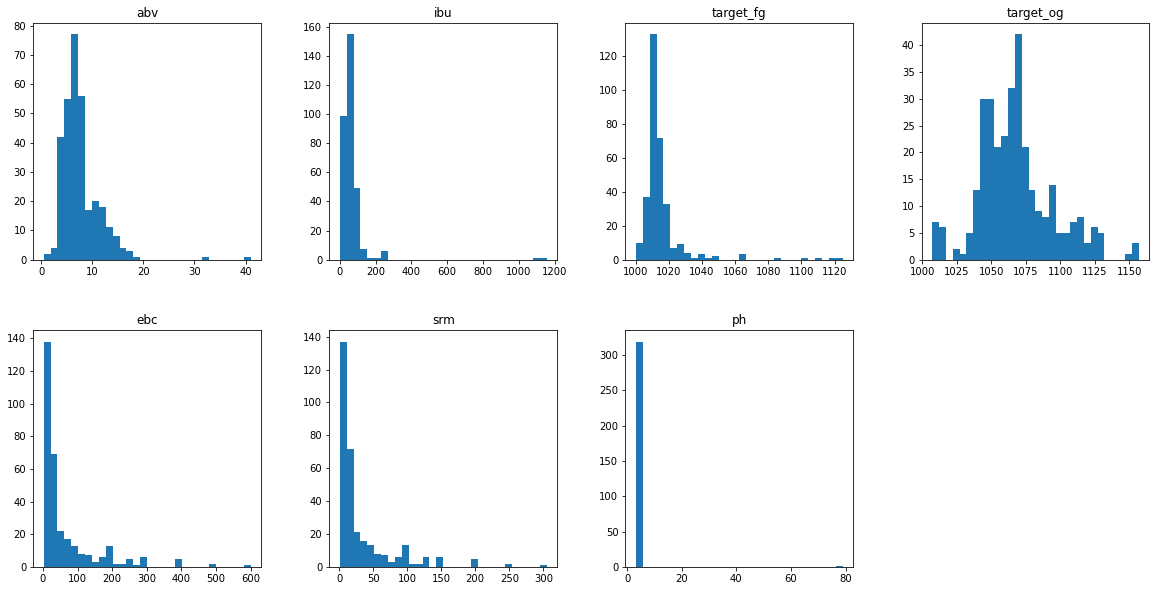

In [178]:
beer_df.hist(figsize=(20,10), grid=False, layout=(2, 4), bins = 30)

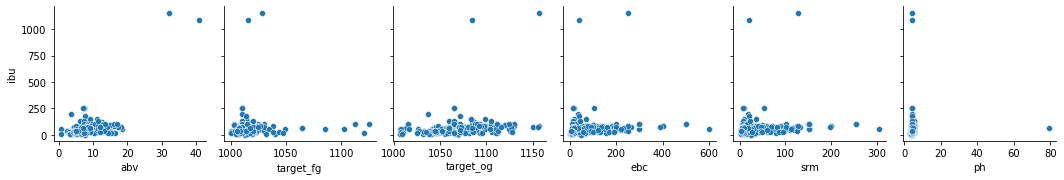

In [179]:
pp = sns.pairplot(data=beer_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph'])


Olhando para o grafico acima podemos observar que duas instancias aparecem com IBU bastante elevado quando comparada com as outras instancias. 

Um fenomeno similar ocorre no PH, mas nesse caso ocorre com apenas uma instancia.

Essas instancias dificultam a analise do grafico de pares. Dessa forma iremos remove-las da base manualmente e posteriormente iremos utilizar tecnicas mais robustas para remocao de outilers.

Posteriormente iremos investigar melhor os outilies em todo dataset e analisar o impacto no modelo.

In [180]:
beer_no_out_df = beer_df[((beer_df['ibu'] < 500) & (beer_df['ph'] < 20))]
beer_no_out_df.shape

(317, 7)

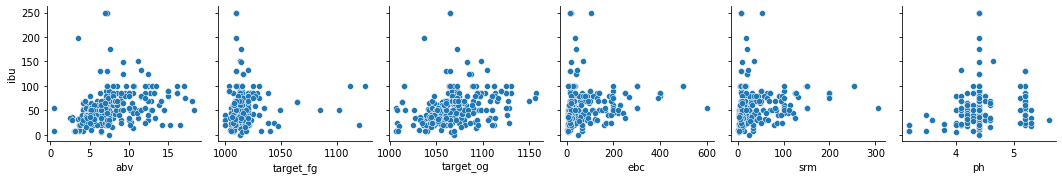

In [181]:
pp = sns.pairplot(data=beer_no_out_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph'])

Apos a remocao das tres instancias, podemos visualizar melhor a correlacao de cada atributo com o IBU. Porem, ainda  é possivel observar alguns pontos que parecem ser outliers. Isso reforca a intuicao de que poderiamos utilizar um metodo de remocao de outliers mais robusto.

**Matriz de Correlacao**

<AxesSubplot:>

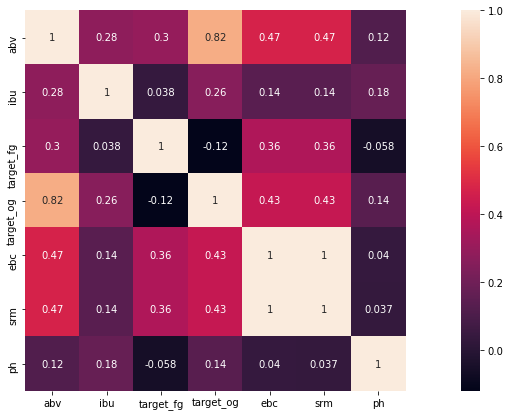

In [182]:
plt.figure(figsize=(20,7))
sns.heatmap(beer_no_out_df.corr(), annot=True, square=True)

O grafico acima mostra que os atributos que tem mais relacao com o IBU sao o ABV e Target OG, apesar que ser uma relacao fraca quando comparada com as relacoes EBC x SRM e ABV x Target OG. 

<AxesSubplot:xlabel='abv', ylabel='target_og'>

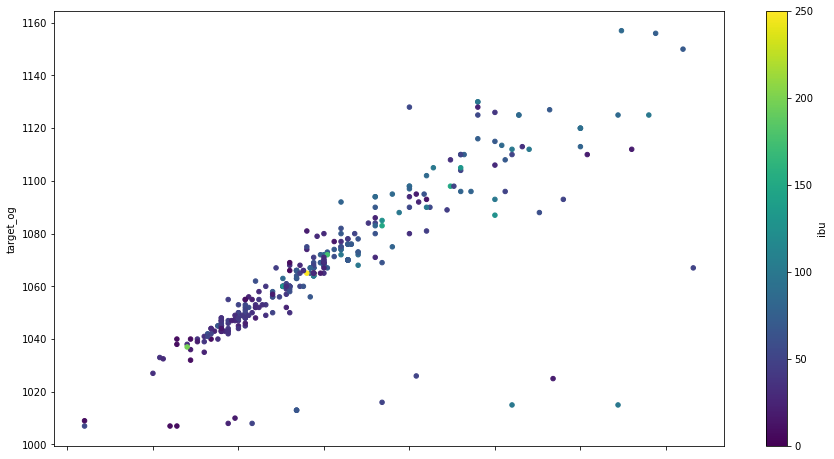

In [219]:
beer_no_out_df.plot.scatter(figsize=(15,8), x='abv', y='target_og',c='ibu', colormap='viridis')

# Modelo de Machine Learning

In [223]:
X_att = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']

X = beer_no_out_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_no_out_df['ibu'].values

### Experimento com Regressores

In [224]:
def predict_ipu(algorithm, X, Y):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)

    feature_importances = []

    # Train the model using the training sets
    algorithm.fit(X_train, y_train)

    if (isinstance(algorithm, GradientBoostingRegressor) or
        isinstance(algorithm, RandomForestRegressor)):
        feature_importances.append(algorithm.feature_importances_)

    y_pred = algorithm.predict(X_test)

    # The mean squared error
    print('Mean squared error: %.2f'
          % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(y_test, y_pred))

#         for test, pred in zip(Y_test, Y_pred):
#             print(test, pred)
   
    print('\n')

    return np.array(feature_importances).mean(axis=0)
 
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')

In [225]:
predict_ipu(LinearRegression(normalize=True), X, Y)

predict_ipu(KNeighborsRegressor(n_neighbors = 4), X, Y)

gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

Mean squared error: 1314.10
Coefficient of determination: 0.06


Mean squared error: 1414.14
Coefficient of determination: -0.01


Mean squared error: 975.69
Coefficient of determination: 0.30




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: Mean of empty slice.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: Mean of empty slice.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean squared error: 941.58
Coefficient of determination: 0.32




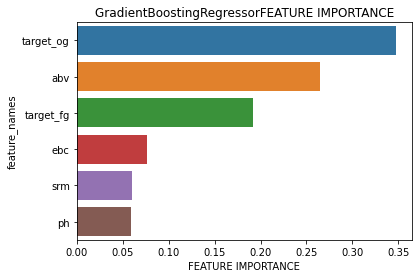

In [226]:
plot_feature_importance(gbr_feature_importances, X_att, 'GradientBoostingRegressor')

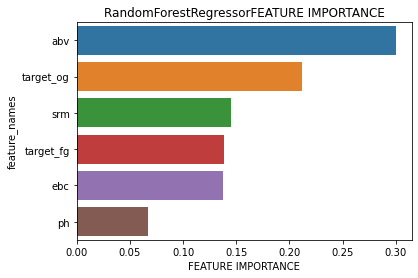

In [227]:
plot_feature_importance(rdf_feature_importances, X_att, 'RandomForestRegressor')

## Remoção de Outilers

Como mencionado anteriormente, algumas instancias parecem ser outilers. O grafico abaixo ilustra essa hipotese.

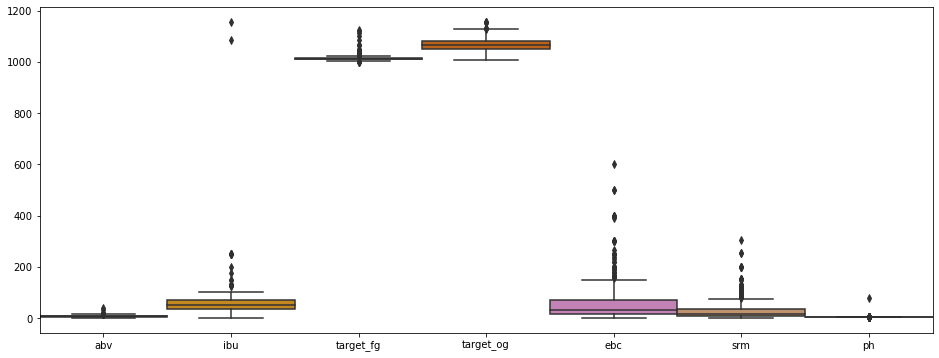

In [228]:
plt.figure(figsize=(16, 6))
bplot = sns.boxplot(data=beer_df, width=1, palette="colorblind")

Desta forma, vamos utilizar o IQR para os outilers e analisar se o resultado se ha melhora no resultado dos experimentos.

In [229]:
Q1 = beer_df.quantile(0.25)
Q3 = beer_df.quantile(0.75)
IQR = Q3 - Q1

beer_noout_df = beer_df[~((beer_df < (Q1 - 1.5 * IQR)) |
                          (beer_df > (Q3 + 1.5 * IQR))).any(axis=1)]

beer_noout_df.shape

(138, 7)

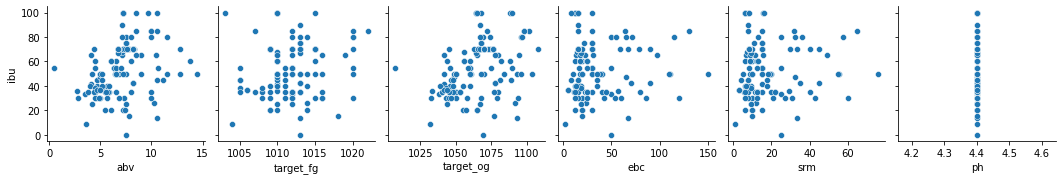

In [230]:
pp = sns.pairplot(data=beer_noout_df,
                  y_vars=['ibu'],
                  x_vars=['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph'])

<AxesSubplot:>

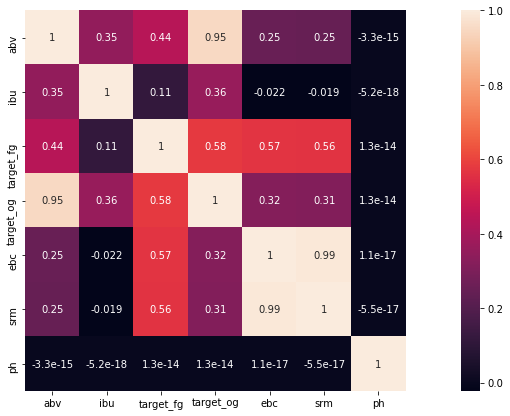

In [231]:
plt.figure(figsize=(20,7))
sns.heatmap(beer_noout_df.corr(), annot=True, square=True)

In [232]:
X = beer_noout_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_noout_df['ibu'].values

In [233]:
gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

Mean squared error: 460.11
Coefficient of determination: 0.21


Mean squared error: 437.15
Coefficient of determination: 0.25




**Usando outra abordagem para remocao de outilers** 

In [236]:
df = beer_df.copy()

for _att in attributes:
    att = df[_att]
    removed_outliers = att.between(att.quantile(.05), att.quantile(.95))
    index_names = df[~removed_outliers].index
    df.drop(index_names, inplace=True)

print('Original dataset:', len(beer_df))
print('Dataset after outlier removal:', len(df))

Original dataset: 320
Dataset after outlier removal: 175


In [235]:
X = df[X_att].values
X = StandardScaler().fit_transform(X)
Y = df['ibu'].values

gbr_feature_importances = predict_ipu(GradientBoostingRegressor(), X, Y)

rdf_feature_importances = predict_ipu(RandomForestRegressor(), X, Y)

Mean squared error: 349.65
Coefficient of determination: -0.16


Mean squared error: 361.61
Coefficient of determination: -0.20




## Experimento com Classificadores

Outra forma de analisar o problema de prever o IBU é utizar classificadores. Nesse caso, iresmo discretizar o IBU em escala te tamanho 10.

In [197]:
beer_discret_df = beer_no_out_df.copy()
beer_discret_df.ibu.describe()

count    317.000000
mean      58.583596
std       38.887518
min        0.000000
25%       35.000000
50%       50.000000
75%       70.000000
max      250.000000
Name: ibu, dtype: float64

In [198]:
min_ibu = beer_discret_df.ibu.min()
max_ibu = beer_discret_df.ibu.max()

bins = list(range(int(min_ibu), int(max_ibu) + 10, 10))
bins_label = bins[1:-1]

beer_discret_df['disc_ibu'] = pd.cut(beer_discret_df['ibu'], bins, include_lowest= True)
beer_discret_df

,abv,ibu,target_fg,target_og,ebc,srm,ph,disc_ibu
0,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4,"(50.0, 60.0]"
1,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4,"(40.0, 50.0]"
2,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2,"(-0.001, 10.0]"
3,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4,"(50.0, 60.0]"
4,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4,"(50.0, 60.0]"
...,...,...,...,...,...,...,...,...
320,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6,"(30.0, 40.0]"
321,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6,"(60.0, 70.0]"
322,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2,"(20.0, 30.0]"
323,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2,"(30.0, 40.0]"


In [211]:
def predict_ipu_classifier(model, X, Y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

In [208]:
X = beer_discret_df[X_att].values
X = StandardScaler().fit_transform(X)
Y = beer_discret_df['disc_ibu'].values
Y = np.array([str(y) for y in Y])

In [209]:
predict_ipu_classifier(KNeighborsClassifier(n_neighbors=3), X, Y)

                precision    recall  f1-score   support

(-0.001, 10.0]       1.00      0.33      0.50         3
  (10.0, 20.0]       0.00      0.00      0.00         2
(120.0, 130.0]       0.00      0.00      0.00         0
(130.0, 140.0]       0.00      0.00      0.00         0
(170.0, 180.0]       0.00      0.00      0.00         0
(190.0, 200.0]       0.00      0.00      0.00         1
  (20.0, 30.0]       0.06      0.33      0.11         3
(240.0, 250.0]       0.50      1.00      0.67         1
  (30.0, 40.0]       0.50      0.33      0.40        12
  (40.0, 50.0]       0.12      0.10      0.11        10
  (50.0, 60.0]       0.25      0.40      0.31         5
  (60.0, 70.0]       1.00      0.47      0.64        15
  (70.0, 80.0]       0.25      0.25      0.25         4
  (80.0, 90.0]       0.00      0.00      0.00         5
 (90.0, 100.0]       1.00      0.67      0.80         3

      accuracy                           0.31        64
     macro avg       0.31      0.26      0.25 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [210]:
predict_ipu_classifier(RandomForestClassifier(max_depth=10, random_state=0), X, Y)

                precision    recall  f1-score   support

(-0.001, 10.0]       1.00      0.33      0.50         3
  (10.0, 20.0]       0.00      0.00      0.00         2
(190.0, 200.0]       0.00      0.00      0.00         1
  (20.0, 30.0]       0.12      0.33      0.18         3
(240.0, 250.0]       0.50      1.00      0.67         1
  (30.0, 40.0]       0.38      0.42      0.40        12
  (40.0, 50.0]       0.10      0.10      0.10        10
  (50.0, 60.0]       0.25      0.20      0.22         5
  (60.0, 70.0]       0.77      0.67      0.71        15
  (70.0, 80.0]       0.25      0.25      0.25         4
  (80.0, 90.0]       0.67      0.40      0.50         5
 (90.0, 100.0]       0.50      0.67      0.57         3

      accuracy                           0.39        64
     macro avg       0.38      0.36      0.34        64
  weighted avg       0.44      0.39      0.40        64



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,